In [1]:
import pandas as pd
import os
import numpy as np 
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import sys
import cufflinks as cf
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.layers import Flatten
from sklearn import metrics

Using TensorFlow backend.


In [2]:
# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline(connected=True)

#--NotebookApp.iopub_msg_rate_limit = 500

In [3]:
path = 'C:\\Users\\Seagate\\Documents\\Python Scripts\\Codes\\Koh\\Grab\\Data\\safety\\features'
os.chdir(path)

In [4]:
def list_files(prefix):
    files = []
    regex = re.compile(prefix + '.*') #String matching
    for file in os.listdir(): #Extract all file in the directroy
        if regex.match(file): #Match the file based on the regex
            if file[-4:] == '.csv': #Ensure it is in csv format
                files.append(file) #Append the file to files
                
    return files

In [5]:
def concat(files):
    dflist = []
    for file in files:
        df = pd.read_csv(file, sep=',', header = 0)
        dflist.append(df)

    concatdf = pd.concat(dflist, axis = 0, ignore_index = True)
    
    return concatdf

In [6]:
def Labeling_dataset(df_feature_0, df_label):
    
    booking_unique = df_feature_0['bookingID'].unique().tolist()
    df_feature_0_copy = df_feature_0.copy()
    df = pd.DataFrame(columns = df_feature_0_copy.columns)

    for i in booking_unique:
        df_label_unique = df_label[df_label['bookingID']==i]
        df_label_value = df_label_unique['label'].values

        df_feature = df_feature_0_copy[df_feature_0_copy['bookingID']==i]
        df_feature['label'] = df_label_value[0]

        df = pd.concat([df, df_feature])

    df = df[['bookingID', 'Accuracy', 'Bearing', 'Speed', 'acceleration_x', 'acceleration_y',
                         'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'label']]

    df = df.sort_index()

    return df
#df.to_csv('Feature_Extracted.csv')

In [7]:
def feature_extraction(df):
    
    df_feature = df.iloc[:, 1:11]
    data = df_feature.values
    data_label = df.label.values
    
    return data, data_label

In [8]:
def reduce_feature_dimensionality_extraction(df):
    
    # Reduce Dimensionality of acceleration and Gyro
    df_feature = df.iloc[:, 1:11]
    df_feature_acc = df.iloc[:, 4:7]
    df_feature_gyro = df.iloc[:, 7:10]

    pca = PCA(n_components = 1)
    pca.fit(df_feature_acc)
    data_acc = pca.transform(df_feature_acc)

    pca = PCA(n_components = 1)
    pca.fit(df_feature_gyro)
    data_gy = pca.transform(df_feature_gyro)

    df_feature['Acc_pca'] = data_acc
    df_feature['Gyro_pca'] = data_gy

    df_feature_new = df_feature.drop(['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'], axis = 1)
    
    data = df_feature_new.values
    data_label = df.label.values
    
    return data, data_label

In [9]:
np.random.seed(42)

In [10]:
def standardscaler(data):
    
    sc = StandardScaler() # StandardScaler lib
    data = sc.fit_transform(data) # fit & transform data based on standard scaler
    
    return data

In [11]:
def MinMaxscaler(data):
    
    M_sc = MinMaxScaler() # StandardScaler lib
    data = M_sc.fit_transform(data) # fit & transform data based on standard scaler
    
    return data

In [12]:
def train_test_split(data, data_label):

    train_size = int(len(data) * 0.67)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    #print(len(train), len(test))

    train_size_label = int(len(data_label) * 0.67)
    test_size_label = len(data_label) - train_size_label
    train_label, test_label = data_label[0:train_size_label], data_label[train_size_label:len(data_label)]
    #print(len(train_label), len(test_label))
    
    return train, test, train_label, test_label

In [13]:
def reshape(trainX, testX):
    
    # reshape input to be [samples, time steps, features]
    trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
    testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX

In [14]:
def Convolutional1D_model():
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 6)))
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', metrics = ['acc'], optimizer='adam')
    
    return model

In [15]:
df_feature_0 = pd.read_csv('part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
df_label = pd.read_csv('part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

df = Labeling_dataset(df_feature_0, df_label)


C:\Users\Seagate\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [16]:
data, data_label = reduce_feature_dimensionality_extraction(df)
data = standardscaler(data)
trainX, testX, trainY, testY = train_test_split(data, data_label)
trainX_knn, testX_knn, trainY_knn, testY_knn = train_test_split(data, data_label)
trainX, testX = reshape(trainX, testX)

In [17]:
model_conv = Convolutional1D_model()
model_conv.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 64)             448       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             8256      
_________________________________________________________________
conv1d_4 (Conv1D)    

In [18]:
history = model_conv.fit(trainX, trainY, epochs = 100, batch_size=512, validation_data = (testX, testY), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 1081081 samples, validate on 532473 samples
Epoch 1/100
 - 24s - loss: 0.6131 - acc: 0.6962 - val_loss: 0.6093 - val_acc: 0.6989
Epoch 2/100
 - 22s - loss: 0.6100 - acc: 0.6986 - val_loss: 0.6086 - val_acc: 0.6996
Epoch 3/100
 - 23s - loss: 0.6093 - acc: 0.6990 - val_loss: 0.6085 - val_acc: 0.6997
Epoch 4/100
 - 22s - loss: 0.6090 - acc: 0.6994 - val_loss: 0.6082 - val_acc: 0.7001
Epoch 5/100
 - 22s - loss: 0.6089 - acc: 0.6996 - val_loss: 0.6080 - val_acc: 0.7003
Epoch 6/100
 - 22s - loss: 0.6087 - acc: 0.6998 - val_loss: 0.6080 - val_acc: 0.7004
Epoch 7/100
 - 22s - loss: 0.6085 - acc: 0.7000 - val_loss: 0.6082 - val_acc: 0.6991
Epoch 8/100
 - 22s - loss: 0.6084 - acc: 0.7001 - val_loss: 0.6077 - val_acc: 0.7006
Epoch 9/100
 - 22s - loss: 0.6083 - acc: 0.7002 - val_loss: 0.6077 - val_acc: 0.7005
Epoch 10/100
 - 22s - loss: 0.6082 - acc: 0.7001 - val_loss: 0.6076 - val_acc: 0.7003
Epoch 11/100
 - 22s - loss: 0.6081 - acc: 0.7004

In [20]:
model_conv.evaluate(testX, testY)

532473/532473 [==============================] - 23s 43us/step


[0.5846963959827899, 0.7134896980693098]

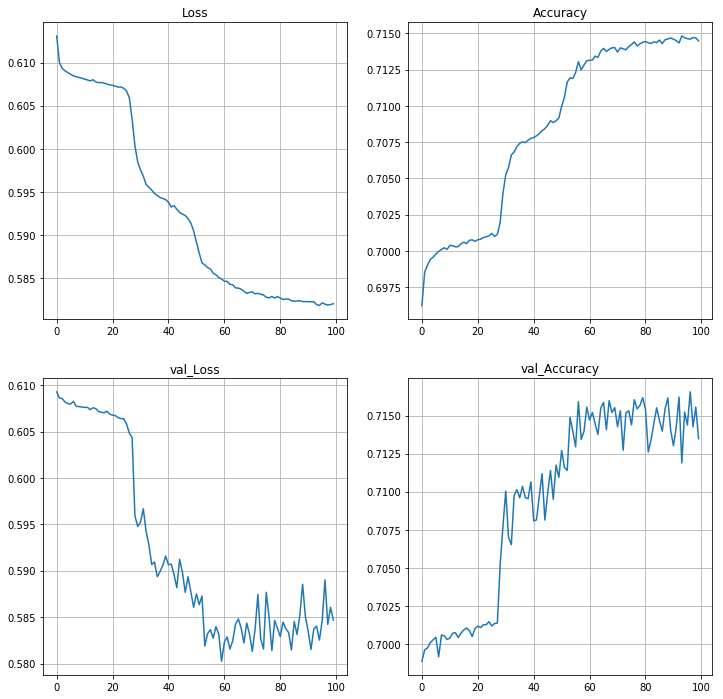

In [21]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.grid()
plt.subplot(222)
plt.plot(history.history['acc'])
plt.title('Accuracy')
plt.grid()
plt.subplot(223)
plt.plot(history.history['val_loss'])
plt.title('val_Loss')
plt.grid()
plt.subplot(224)
plt.plot(history.history['val_acc'])
plt.title('val_Accuracy')
plt.grid()